In [1]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from Parser import parse_frames
from scipy.signal import medfilt
from Functions import analyse_each_rep, find_extremas, filter_extremas, numpy_fillna, DTWDistance
from JointAngles import JointAngles
import numpy as np
import glob
import os
import pickle
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt


In [4]:
#input_folder = "C:\\Users\\altaok\\Documents\\GitHub\\IndividualProject\\keypoints_for_all\\triceps pushdown"
input_folder = 'C:\\Users\\ak5u16\\Desktop\\IndividualProject\\keypoints_for_all\\triceps_pushdown'
folder_paths = glob.glob(os.path.join(input_folder, 'triceps_pushdown*'))
points_folder_name = os.path.basename(input_folder)


def get_data_for_dataset(folder_paths, points_folder_name):
    angle_label_dict = {}
    data = {}
    # need to have a dict with keys : uf_points, ut_points, tk_points; where dict[key] = [([p], 0/1)]; append(([p], 0/1))
    #labeled_arrays = {0:[()], 1:[()]}
    angle_arrays = []
    if points_folder_name == 'triceps_pushdown': 
        for folder in folder_paths:
            video_name = os.path.basename(folder)
            label = 0 if '_correct' in folder else 1
            frame_poses = parse_frames(folder)
            joint_angles = JointAngles(points_folder_name, frame_poses)


            upArm_forearm_angles = np.array(joint_angles.upArm_forearm_angles)
            upArm_forearm_angles = np.nan_to_num(upArm_forearm_angles)
            upArm_forearm_angles_filtered = medfilt(medfilt(upArm_forearm_angles, 5), 5)
            #labeled_arrays[label][0] = labeled_arrays[label][0] + (upArm_forearm_angles_filtered)

            upArm_trunk_angles = np.array(joint_angles.upArm_trunk_angles)
            upArm_trunk_angles = np.nan_to_num(upArm_trunk_angles)
            upArm_trunk_angles_filtered = medfilt(medfilt(upArm_trunk_angles, 5), 5)
            #labeled_arrays[label][0] = labeled_arrays[label][0] + (upArm_trunk_angles_filtered)

            trunk_knee_angles = np.array(joint_angles.trunk_knee_angles)
            trunk_knee_angles = np.nan_to_num(trunk_knee_angles)
            trunk_knee_angles_filtered = medfilt(medfilt(trunk_knee_angles, 5), 5)
            #labeled_arrays[label][0] = labeled_arrays[label][0] + (trunk_knee_angles_filtered)

            #number of reps 
            upArm_forearm_minimas = filter_extremas(upArm_forearm_angles_filtered, find_extremas(upArm_forearm_angles_filtered, maxima=False), maxima=False) 

            angle_arrays.append((label, upArm_forearm_minimas, [upArm_forearm_angles_filtered, upArm_trunk_angles_filtered, trunk_knee_angles_filtered]))

    else: 
        print('Error: Wrong folder path! Has to be: triceps pushdown')

    return angle_arrays
                                             
                                    

def fill_dataframe(angle_arrays, exercise_folder_name):
    df_tup = (None,None,None)
    
    print('Filling dataset with ' + str(exercise_folder_name) + ' data...')
   
    for tup in angle_arrays:
        label = tup[0]
        extremas = tup[1]
        uf_angles, ut_angles, tk_angles = tup[2]

        # Extract rep angles
        uf_angles, ut_angles, tk_angles = analyse_each_rep('triceps_pushdown', 'dataset', extremas, uf_angles, ut_angles, tk_angles)
        s1 = pd.Series(uf_angles, name='Angle_array')
        s1a = pd.Series([label for n in range(len(uf_angles))], name='Label')
        df1 = pd.concat([s1,s1a], axis=1)
               
        s2 = pd.Series(ut_angles, name='Angle_array')
        s2a = pd.Series([label for n in range(len(ut_angles))], name='Label')
        df2 = pd.concat([s2,s2a], axis=1)
        
        s3 = pd.Series(tk_angles, name='Angle_array')
        s3a = pd.Series([label for n in range(len(tk_angles))], name='Label')
        df3 = pd.concat([s3,s3a], axis=1)
        
        df_tup = (pd.concat([df_tup[0],df1]), pd.concat([df_tup[1], df2]), pd.concat([df_tup[2],df3]))
        #pd.concat(df_list).reset_index(drop=True)

    return df_tup


        

In [11]:
#filter uf_df
def filter_uf_df(vals, df):
    idx_ls = []
    for x in vals:
        if x[:1][0] > 120 or x[-1:][0] > 120 or (x[:1][0] > 120 and x[-1:][0] > 120): 
            #print(x)
            ls_1 = df['Angle_array'].index.tolist()
            ls_2 = df['Angle_array'].values.tolist()
            hm = {}
         
            for i, j in zip(ls_1, ls_2):
                hm[i] = j
            index = 0
            for k, v in hm.items():
                if np.array_equal(v,x):
                    index = k  
                    idx_ls.append(index)
                    print('Deleted entry', index)
    df = df.drop(idx_ls)
        
    return df 

#filter ut_df
def filter_ut_df(vals, df):
    idx_ls = []
    for x in vals:
        if x[:1][0] > 25 or x[-1:][0] > 25 or (x[:1][0] > 25 and x[-1:][0] > 25): 
            #print(x)
            ls_1 = df['Angle_array'].index.tolist()
            ls_2 = df['Angle_array'].values.tolist()
            hm = {}
         
            for i, j in zip(ls_1, ls_2):
                hm[i] = j
            index = 0
            for k, v in hm.items():
                if np.array_equal(v,x):
                    index = k  
                    idx_ls.append(index)
                    print('Deleted entry', index)
    df = df.drop(idx_ls)
        
    return df 

#filter tk_df
def filter_tk_df(vals, df):
    idx_ls = []
    for x in vals:
        if x[:1][0] < 140 or x[-1:][0] < 140 or (x[:1][0] < 140 and x[-1:][0] < 140): 
            #print(x)
            ls_1 = df['Angle_array'].index.tolist()
            ls_2 = df['Angle_array'].values.tolist()
            hm = {}
         
            for i, j in zip(ls_1, ls_2):
                hm[i] = j
            index = 0
            for k, v in hm.items():
                if np.array_equal(v,x):
                    index = k  
                    idx_ls.append(index)
                    print('Deleted entry', index)
    df = df.drop(idx_ls)
        
    return df 


In [5]:
angle_arrays = get_data_for_dataset(folder_paths, points_folder_name) 
df_tup = fill_dataframe(angle_arrays, points_folder_name)


Filling dataset with triceps_pushdown data...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 283 entries, 0 to 12
Data columns (total 2 columns):
Angle_array    283 non-null object
Label          283 non-null int64
dtypes: int64(1), object(1)
memory usage: 6.6+ KB
None


In [12]:
uf_df = df_tup[0]
print(uf_df.info())
uf_df = filter_uf_df(uf_df.Angle_array.values, uf_df)
print(uf_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283 entries, 0 to 12
Data columns (total 2 columns):
Angle_array    283 non-null object
Label          283 non-null int64
dtypes: int64(1), object(1)
memory usage: 6.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 283 entries, 0 to 12
Data columns (total 2 columns):
Angle_array    283 non-null object
Label          283 non-null int64
dtypes: int64(1), object(1)
memory usage: 6.6+ KB
None


In [25]:
maxx = []
for n in ut_df.Angle_array.values:
    maxx.append(np.max(n))

for m in maxx:
    if m>25:
        print(m)

25.864835635864125
36.6585337753671
34.488033058522845
29.95274668883566
28.15177075649278
51.58890555614554
51.60390677604522
42.830469171219264
47.863359928241266
43.549658528820366
47.41024684588303
48.63443267215703
54.3415008623092
50.94320060172021
47.74101999762764
48.485584228224035
54.37685496453951
69.46848921485925
52.1394507118198
59.64081332728357
48.824107240494115
46.39793414009085
45.1083387210066
32.880294075052
26.59150511914453
41.27730433631633
41.17381656658756
38.63412468127322
42.06651003354248
44.44441131232929


In [20]:
ut_df = df_tup[1]
print(ut_df.head())
#
ut_df = filter_ut_df(ut_df.Angle_array.values, ut_df)
print(ut_df.info())

                                         Angle_array  Label
0  [12.492020774347218, 12.492020774347218, 12.49...      0
1  [14.41168152188108, 15.145721551859719, 15.145...      0
2  [12.363995874074773, 12.363995874074773, 12.27...      0
3  [13.158830214650166, 13.158830214650166, 12.67...      0
4  [11.00732435121932, 11.00732435121932, 11.0073...      0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 283 entries, 0 to 12
Data columns (total 2 columns):
Angle_array    283 non-null object
Label          283 non-null int64
dtypes: int64(1), object(1)
memory usage: 16.6+ KB
None


In [ ]:
ut_df = df_tup[1]


In [ ]:
tk_df = df_tup[2]

In [10]:
4<3 or (5>4>3)

True

Do the filtering 

# Clustering


In [69]:
a =[1,2]
print(a[-1:])

[2]


Need to filter the dataset; for array in array_list: if array[:1] > 120  and array[-1:] > 120 then remove

In [2]:
df = pickle.load( open( "datasets/triceps_df.pickle", "rb" ) )

df.head()

,Angle_array,Label
0,"[99.92144582524506, 105.98385101730454, 113.21...",0
1,"[12.492020774347218, 12.492020774347218, 12.49...",0
2,"[173.55197279771207, 173.55197279771207, 173.5...",0
3,"[94.52428256779325, 94.52428256779325, 97.5730...",0
4,"[14.41168152188108, 15.145721551859719, 15.145...",0


In [3]:
new_df = df[df['Label'] == 0]
series = new_df.Angle_array.values.tolist()

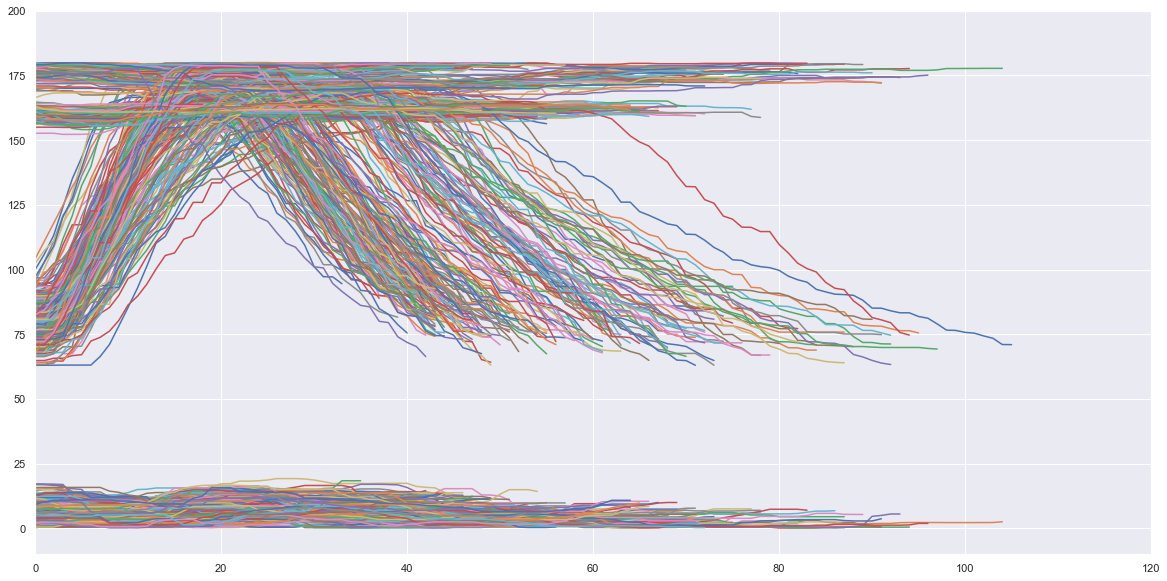

In [189]:
from dtaidistance import dtw, clustering
import seaborn as sns;sns.set()

#print(series)

#model1 = clustering.Hierarchical(dtw.distance_matrix_fast, {})
#cluster_idx = model1.fit(series)
# Augment Hierarchical object to keep track of the full tree
#model2 = clustering.HierarchicalTree(model1)
#cluster_idx = model2.fit(series)
# SciPy linkage clustering
#model = clustering.LinkageTree(dtw.distance_matrix_fast, {}, method='single')
#cluster_idx = model.fit(series)

timeseries = pd.DataFrame()
ax = None
plt.figure(figsize=(20, 10))
plt.xlim(0, 120)
plt.ylim(-10, 200)
for ts in series:
    df_ts = pd.DataFrame(ts)
    #print(df_ts.head())
    #print(df_ts.values)
    timeseries = timeseries.append(df_ts)
    #print('ye')
    ax = sns.lineplot(ax=ax,data=ts)

plt.show()


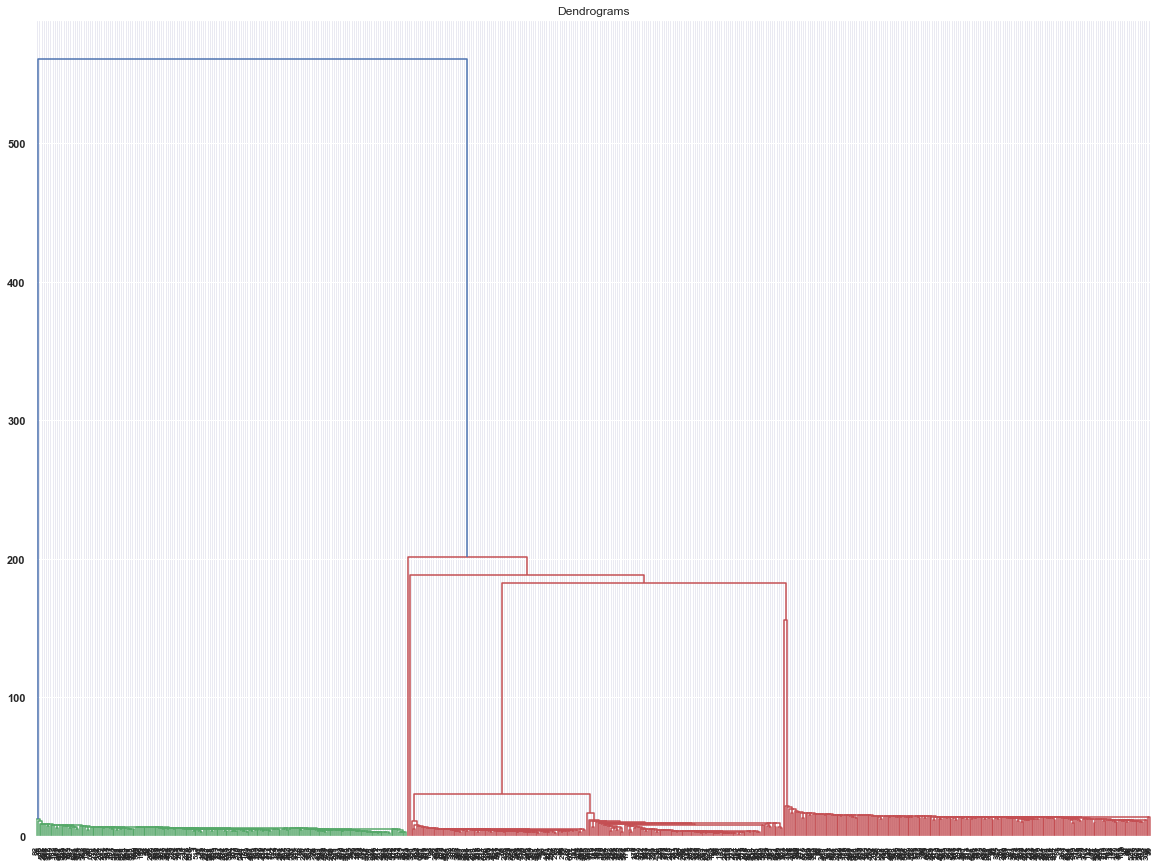

In [14]:
import scipy.cluster.hierarchy as shc
from dtaidistance import dtw, clustering
font = {'weight' : 'bold',
        'size'   : 20}
new_df = df[df['Label'] == 0]
plt.rc('font', **font)
plt.figure(figsize=(20, 15))  
plt.title("Dendrograms")  
Z = shc.linkage(numpy_fillna(new_df['Angle_array'].values),  method='single', metric=dtw.distance_fast)
dend = shc.dendrogram(Z, leaf_font_size=8.)

In [190]:
from sklearn.cluster import AgglomerativeClustering
from tslearn.utils import to_time_series_dataset


#ts_df = to_time_series_dataset(series)
#print(ts_df)

ds2 = dtw.distance_matrix_fast(series)
#print(ds2)
ds2[ds2 == np.inf] = 0
cluster = AgglomerativeClustering(n_clusters=None, affinity='precomputed', compute_full_tree=True, linkage='single', distance_threshold=182.)  
pred = cluster.fit_predict(ds2)


In [191]:
cluster.n_clusters_

4

In [192]:
new_df['new_labels'] = cluster.labels_

C:\Apps\Anaconda3\envs\gpu-cuda10\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [193]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 612 entries, 0 to 611
Data columns (total 3 columns):
Angle_array    612 non-null object
Label          612 non-null int64
new_labels     612 non-null int64
dtypes: int64(2), object(1)
memory usage: 19.1+ KB


In [204]:
clusters = np.unique(cluster.labels_)
clusters_arrays = []

for n in clusters:
    np_ls = np.array([])
    vs = new_df[new_df['new_labels'] == n].Angle_array.values
    
    print(n, np.append(np_ls, vs).size)
    #print(len(clusters_arrays))


0 203
1 204
2 1
3 204


In [206]:
cluster0_df = new_df[new_df['new_labels'] == 0]
cluster1_df = new_df[new_df['new_labels'] == 1]
cluster2_df = new_df[new_df['new_labels'] == 2]
cluster3_df = new_df[new_df['new_labels'] == 3]

print(cluster0_df.head())
print(cluster1_df.head())
print(cluster2_df.head())
print(cluster3_df.head())


                                          Angle_array  Label  new_labels
0   [99.92144582524506, 105.98385101730454, 113.21...      0           0
3   [94.52428256779325, 94.52428256779325, 97.5730...      0           0
6   [95.8773111975647, 95.8773111975647, 99.663043...      0           0
9   [89.32800468158571, 89.32800468158571, 89.5034...      0           0
12  [86.12571966492459, 86.12571966492459, 91.5572...      0           0
                                          Angle_array  Label  new_labels
2   [173.55197279771207, 173.55197279771207, 173.5...      0           1
5   [173.22139817620604, 173.22139817620604, 172.9...      0           1
8   [173.03115665527125, 173.03115665527125, 173.0...      0           1
11  [175.2258681017381, 175.4708311471744, 175.566...      0           1
14  [175.9961169176449, 175.9961169176449, 176.573...      0           1
                                           Angle_array  Label  new_labels
591  [67.13796955831708, 74.39161882696298, 75.752

clustering again after filtering new_df

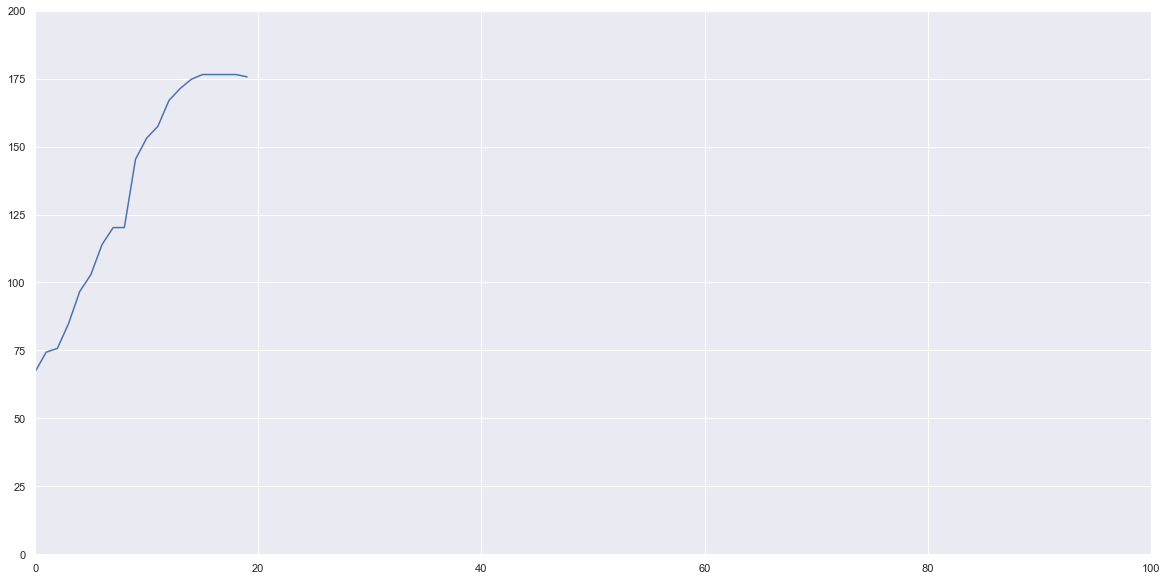

In [208]:
ax = None
plt.figure(figsize=(20, 10))
plt.xlim(0,100)
plt.ylim(0,200)
for ts in cluster2_df.Angle_array.values:
    #print(ts)
    ax = sns.lineplot(ax=ax,data=ts)
    
plt.show()


In [166]:
new_df = df[df['Label'] == 0]
series = new_df.Angle_array.values.tolist()
#print(series)

ds2 = dtw.distance_matrix_fast(series)
#print(ds2)
ds2[ds2 == np.inf] = 0
cluster = AgglomerativeClustering(n_clusters=None, affinity='precomputed', compute_full_tree=True, linkage='single', distance_threshold=182.)  
pred = cluster.fit_predict(ds2)

clusters = np.unique(cluster.labels_)
clusters_arrays = []
for n in clusters:
    if n!=2:
        clusters_arrays.append(np.array([np_arrs for np_arrs in new_df[new_df['new_labels'] == n].Angle_array.values]))
print(len(clusters_arrays))
for n in clusters_arrays:
    print(n.size)


1
202


<class 'pandas.core.frame.DataFrame'>
Int64Index: 612 entries, 0 to 611
Data columns (total 3 columns):
Angle_array    612 non-null object
Label          612 non-null int64
new_labels     612 non-null int64
dtypes: int64(2), object(1)
memory usage: 19.1+ KB


In [245]:
cluster1 = pred[pred == 0]
cluster2 = pred[pred == 1]
cluster3 = pred[pred == 2]
cluster4 = pred[pred == 3]
cluster5 = pred[pred == 4]
print('cluster 1 size', cluster1.size)
print('cluster 2 size', cluster2.size)
print('cluster 3 size', cluster3.size)
print('cluster 4 size', cluster4.size)
print('cluster 5 size', cluster5.size)

cluster 1 size 203
cluster 2 size 204
cluster 3 size 1
cluster 4 size 204
cluster 5 size 0


In [71]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset

ts_df = to_time_series_dataset(new_df['Angle_array'].values)
                               
km = TimeSeriesKMeans(n_clusters=3, metric="dtw")
km.fit(ts_df)
centroids = km.cluster_centers_


In [64]:
km.cluster_centers_.shape

(3, 19, 1)

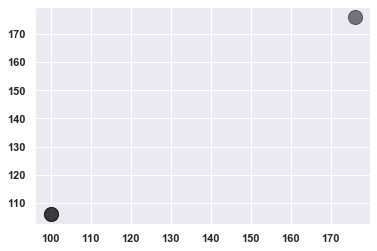

In [75]:

centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);


In [77]:
pred2 = km.labels_
#print(pred2)
cluster1 = pred2[pred2 == 0]
cluster2 = pred2[pred2 == 1]
cluster3 = pred2[pred2 == 2]
cluster4 = pred2[pred2 == 3]
#cluster5 = pred[pred == 4]
print('cluster 1 size', cluster1.size)
print('cluster 2 size', cluster2.size)
print('cluster 3 size', cluster3.size)
print('cluster 4 size', cluster4.size)
#print('cluster 5 size', cluster5.size)

cluster 1 size 134
cluster 2 size 478
cluster 3 size 0
cluster 4 size 0


In [101]:
from scipy.cluster.hierarchy import fcluster

def print_clusters(ts, Z, k, plot=False):
    # k Number of clusters I'd like to extract
    results = fcluster(Z, k, criterion='inconsistent')

    # check the results
    s = pd.Series(results)
    clusters = s.unique()
    print(clusters)

    for c in clusters:
        cluster_indeces = s[s==c].index
        print("Cluster %d number of entries %d" % (c, len(cluster_indeces)))
        if plot:
            ts.Angle_array.T.iloc[:,cluster_indeces].plot()
            plt.show()

print_clusters(new_df, Z, 1.2, plot=False)

[1]
Cluster 1 number of entries 612


In [17]:
from sklearn.model_selection import train_test_split
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

y = df['Label']
x = df['Angle_array']
#x = numpy_fillna(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print(X_train.shape)
print(X_test.shape)

(594,)
(255,)


In [18]:
k_range = range(1, 2) #26
scores = {}
scores_list = []
for k in k_range:
    knn_clf = KNeighborsTimeSeriesClassifier(n_neighbors=k, metric="dtw", n_jobs=-1)
    #knn_clf = KNeighborsClassifier(k, n_jobs=-1)
    knn_clf.fit(numpy_fillna(X_train.values), y_train)
    predicted_labels = knn_clf.predict(numpy_fillna(X_test.values))
    acc = metrics.accuracy_score(y_test, predicted_labels)
    scores[k] = acc
    print("Correct classification rate:", acc)
    print('\n')
    print(metrics.classification_report(y_test, predicted_labels))
    print(metrics.f1_score(y_test, predicted_labels, average='macro'))


Correct classification rate: 0.9372549019607843


              precision    recall  f1-score   support

           0       0.95      0.95      0.95       174
           1       0.90      0.90      0.90        81

    accuracy                           0.94       255
   macro avg       0.93      0.93      0.93       255
weighted avg       0.94      0.94      0.94       255

0.9276287782034909


In [64]:
with open('datasets/triceps_df.pickle', 'wb') as f:
    pickle.dump(df, f)